In [1]:
import pandas as pd
import numpy as np
import os
import re 
import tensorflow as tf;
import plotly as py
import plotly.graph_objs as go
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import time
import copy

from torch import Tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torchvision import transforms, datasets, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from PIL import Image, ImageOps
from numpy import vstack

https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

In [2]:
torch.cuda.is_available()

False

In [2]:
path = '../data/COVID-19_Radiography_Dataset/'

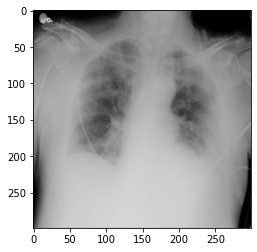

In [3]:
teste = cv2.imread(path+'Covid/COVID-1.png') 
plt.imshow(cv2.cvtColor(teste, cv2.COLOR_BGR2RGB)) 

#### Montando o dataset mapeando as imgs e as classes

In [4]:
list_dir = []
for filename in sorted(os.listdir(path)):
    list_dir.append(path+filename) 

In [5]:
list_dir

['../data/COVID-19_Radiography_Dataset/Covid',
 '../data/COVID-19_Radiography_Dataset/Normal',
 '../data/COVID-19_Radiography_Dataset/ViralPneumonia']

In [6]:
list_dir[0][list_dir[0].find("19_Radiography_Dataset"):].split('/')[1]

'Covid'

In [7]:
list_path = []
list_class = []
for dire in list_dir:
    position = dire.find("19_Radiography_Dataset")
    #path_imgs = sorted(os.listdir(dire))
    path_imgs = [os.path.join(dire[position:].split('/')[1], x) for x in sorted(os.listdir(dire))]
    classe = [dire[position:].split('/')[1] for x in path_imgs]
    
    list_path.extend(path_imgs)
    list_class.extend(classe)


In [8]:
df_images = pd.DataFrame(columns=['path', 'class'])
df_images['path'] = pd.Series(list_path)
df_images['class'] = pd.Series(list_class)
df_images = df_images.sample(frac=1).reset_index(drop=True)

df_images

,path,class
0,Normal/Normal-1563.png,Normal
1,Normal/Normal-5609.png,Normal
2,Normal/Normal-6616.png,Normal
3,Normal/Normal-3868.png,Normal
4,Covid/COVID-836.png,Covid
...,...,...
15148,ViralPneumonia/Viral Pneumonia-411.png,ViralPneumonia
15149,Normal/Normal-10117.png,Normal
15150,Normal/Normal-3138.png,Normal
15151,Normal/Normal-2947.png,Normal


<AxesSubplot:>

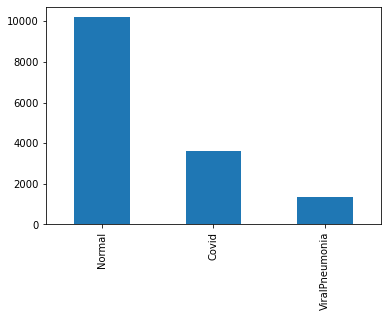

In [9]:
df_images['class'].value_counts().plot(kind='bar')

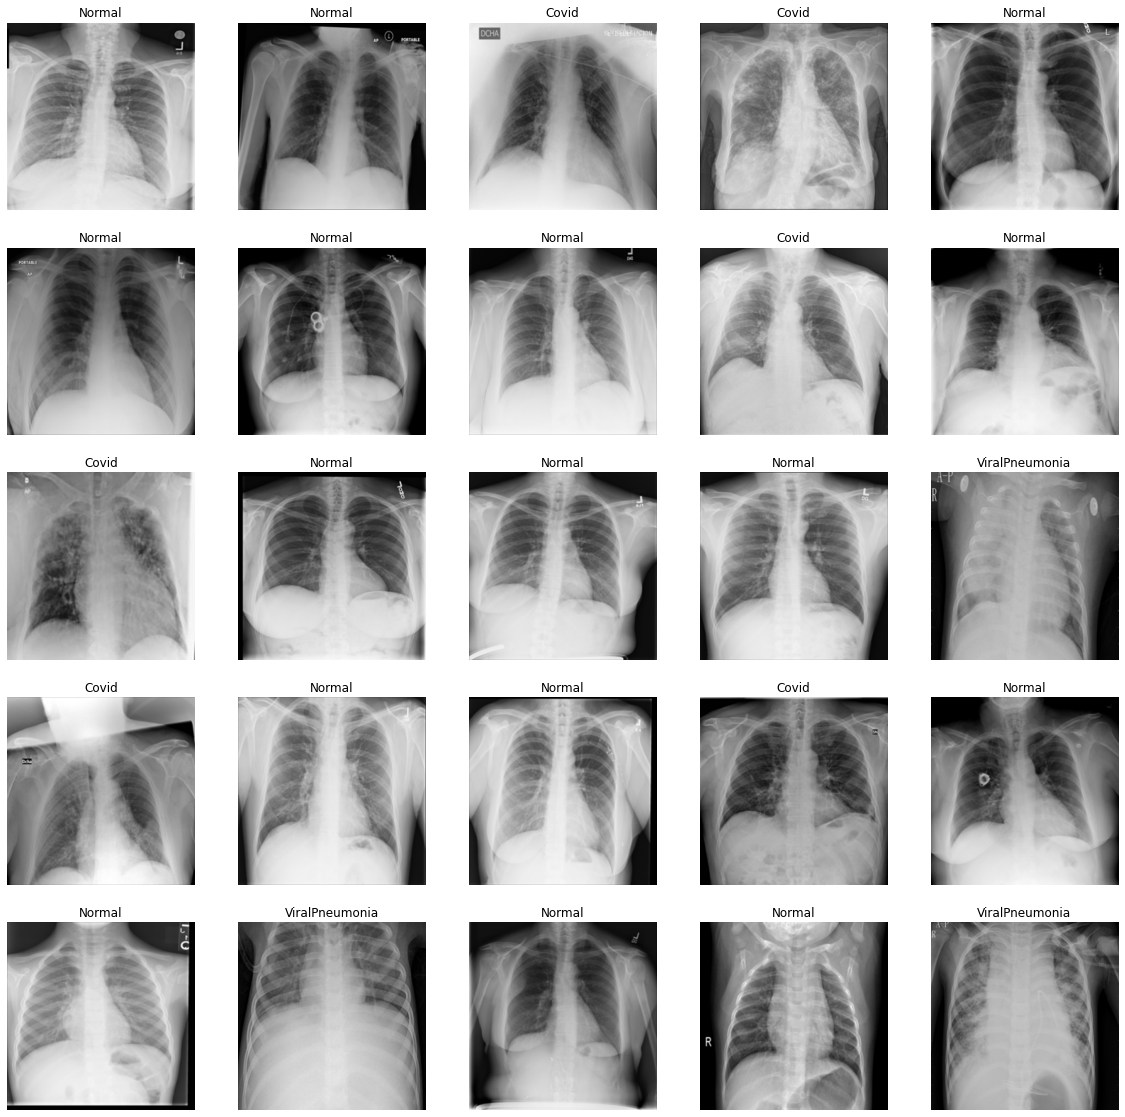

In [10]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,3000,25))): 
    
    imagem=cv2.imread(path+df_images['path'][i])
    plt.subplot(5,5,n+1)
    plt.imshow(cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB))
    plt.title(df_images['class'][i])
    plt.axis('off')     
plt.show()

#### Preparando dataset

In [89]:
# class radiographyDataset(Dataset):
    
#     def __init__(self, image_path, classe, transform=None):

#         self.img_dir = image_path
        
#         le = LabelEncoder()
#         le.fit(df_images['class'].values)
#         self.y = le.transform(classe)
#         #self.y = classe
#         self.transform = transform
         
#     # obtem uma linha do dataset
#     def __getitem__(self, idx):
#         img = Image.open(os.path.join(path,self.img_dir[idx]))
#         img = ImageOps.grayscale(img)
#         #img = cv2.imread(os.path.join(path,self.img_dir[idx])) 
#         if self.transform is not None:
#             img = self.transform(img)
        
#         label = self.y[idx]
#         return img, label
           
#     def __len__(self):
#         return len(self.y)
    

In [38]:
,class radiographyDataset(Dataset):
    
    def __init__(self, dataframe, transform=None):

        self.img_dir = dataframe['path']
        y = dataframe['class']
        le = LabelEncoder()
        self.y = le.fit_transform(y)
        #self.y = classe
        self.transform = transform
         
    # obtem uma linha do dataset
    def __getitem__(self, idx):
        img = Image.open(os.path.join(path,self.img_dir[idx]))
        #Estava dando erro na normalizacao, por isso converti aqui para cinza
        img = ImageOps.grayscale(img)
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[idx]
        return img, label
           
    def __len__(self):
        return len(self.y)
    

#### Transforms e data loader

In [39]:
batch_size = 16
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([64, 64]),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(64, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        #transforms.Normalize([0.5, 0.5, 0.5],
                             #[0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize([64, 64]),
        transforms.ToTensor(),
        #transforms.Normalize([0.5, 0.5, 0.5],
                             #[0.5, 0.5, 0.5])
    ]),
}

data_train,data_test = train_test_split(df_images,test_size=0.20,random_state=42)
data_train,data_test = data_train.reset_index(),data_test.reset_index()

image_datasets = {'train': radiographyDataset(data_train,data_transforms['train']),
                  'val': radiographyDataset(data_test,data_transforms['val'])}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#device = torch.device('cpu')

In [40]:
dataset_sizes

{'train': 12122, 'val': 3031}

<AxesSubplot:>

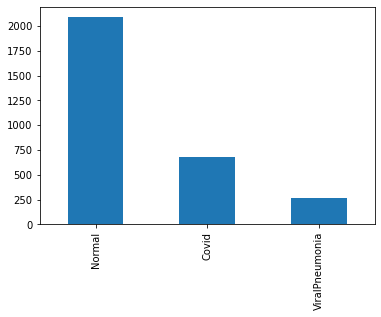

In [41]:
data_test['class'].value_counts().plot(kind='bar')

#### Modelo

In [46]:
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        #self.drop_out = nn.Dropout()
        # 64x6x8 (widht, height, out_channels) /2 (MaxPool2d) = 16384 /2 (MaxPool2d) = 8192
        self.fc1 = nn.Linear(8192, 64)
        self.fc2 = nn.Linear(64, num_classes)


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = torch.flatten(out, 1)
        #out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        #out = F.log_softmax(out, dim = 1)
        return out   

In [47]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #print(outputs.shape, labels.shape)
                    _, preds = torch.max(outputs, 1)
                    
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} -> Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())   
        .001
    time_elapsed = time.time() - since
    print('Treino completo em {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Melhor valor de acurácia: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#### Treinando o modelo

In [124]:
num_classes = 3
num_epochs = 20
learning_rate = 0.005

model = ConvNet(num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [125]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs)

Epoch 0/59
----------
train -> Loss: 0.6247 Acc: 0.7207
val -> Loss: 0.5734 Acc: 0.7268
Epoch 1/59
----------
train -> Loss: 0.4621 Acc: 0.7973
val -> Loss: 0.3848 Acc: 0.8387
Epoch 2/59
----------
train -> Loss: 0.4176 Acc: 0.8195
val -> Loss: 0.3754 Acc: 0.8499
Epoch 3/59
----------
train -> Loss: 0.3892 Acc: 0.8299
val -> Loss: 0.3189 Acc: 0.8634
Epoch 4/59
----------
train -> Loss: 0.3651 Acc: 0.8440
val -> Loss: 0.3337 Acc: 0.8624
Epoch 5/59
----------
train -> Loss: 0.3505 Acc: 0.8510
val -> Loss: 0.3382 Acc: 0.8581
Epoch 6/59
----------
train -> Loss: 0.3349 Acc: 0.8570
val -> Loss: 0.3056 Acc: 0.8750
Epoch 7/59
----------
train -> Loss: 0.2815 Acc: 0.8847
val -> Loss: 0.2582 Acc: 0.8931
Epoch 8/59
----------
train -> Loss: 0.2681 Acc: 0.8863
val -> Loss: 0.2543 Acc: 0.8934
Epoch 9/59
----------
train -> Loss: 0.2609 Acc: 0.8916
val -> Loss: 0.2436 Acc: 0.9007
Epoch 10/59
----------
train -> Loss: 0.2600 Acc: 0.8917
val -> Loss: 0.2447 Acc: 0.9014
Epoch 11/59
----------
train ->

In [62]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in dataloaders['val']:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

- 0 = Covid
- 1 = Normal
- 2 = ViralPneumonia

In [63]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83        56
           1       0.93      0.91      0.92       119
           2       1.00      0.93      0.97        15

    accuracy                           0.89       190
   macro avg       0.91      0.90      0.90       190
weighted avg       0.90      0.89      0.90       190



In [65]:
cm =  confusion_matrix(y_true_list, y_pred_list)
cm

array([[ 48,   8,   0],
       [ 11, 108,   0],
       [  1,   0,  14]])

In [66]:
torch.save(model.state_dict(), "rad_classifier.pt") 

### Teste com balanceamento das classes

In [95]:
y_train = []
with torch.no_grad():
    for x_batch, y_batch in dataloaders['train']:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_train.append(y_batch.cpu().numpy())
y_train = np.array([item for sublist in y_train for item in sublist])

In [106]:
y_train

array([1, 1, 1, ..., 0, 0, 1])

In [110]:
class_weights=class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
class_weights=torch.tensor(class_weights,dtype=torch.float)

In [126]:
num_classes = 3
num_epochs = 20
learning_rate = 0.005

model2 = ConvNet(num_classes)
model2 = model2.to(device)

criterion2 = nn.CrossEntropyLoss(weight=class_weights)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=learning_rate, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler2 = lr_scheduler.StepLR(optimizer2, step_size=7, gamma=0.1)

In [127]:
model2 = train_model(model2, criterion2, optimizer2, exp_lr_scheduler2, num_epochs)

Epoch 0/59
----------
train -> Loss: 0.6714 Acc: 0.6414
val -> Loss: 0.5292 Acc: 0.7344
Epoch 1/59
----------
train -> Loss: 0.5076 Acc: 0.7264
val -> Loss: 0.4256 Acc: 0.7621
Epoch 2/59
----------
train -> Loss: 0.4702 Acc: 0.7505
val -> Loss: 0.4101 Acc: 0.7357
Epoch 3/59
----------
train -> Loss: 0.4527 Acc: 0.7569
val -> Loss: 0.4134 Acc: 0.7103
Epoch 4/59
----------
train -> Loss: 0.4240 Acc: 0.7726
val -> Loss: 0.3456 Acc: 0.8123
Epoch 5/59
----------
train -> Loss: 0.4044 Acc: 0.7873
val -> Loss: 0.3399 Acc: 0.8265
Epoch 6/59
----------
train -> Loss: 0.3841 Acc: 0.7923
val -> Loss: 0.3572 Acc: 0.7760
Epoch 7/59
----------
train -> Loss: 0.3181 Acc: 0.8275
val -> Loss: 0.2921 Acc: 0.8482
Epoch 8/59
----------
train -> Loss: 0.3007 Acc: 0.8408
val -> Loss: 0.2890 Acc: 0.8525
Epoch 9/59
----------
train -> Loss: 0.3048 Acc: 0.8404
val -> Loss: 0.2838 Acc: 0.8496
Epoch 10/59
----------
train -> Loss: 0.2942 Acc: 0.8414
val -> Loss: 0.2788 Acc: 0.8657
Epoch 11/59
----------
train ->